In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),  # 1*3*3*4 + 4 = 40 params
            nn.ReLU(),
            nn.BatchNorm2d(4),              # 8 params
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=1),  # 4*3*3*8 + 8 = 296 params
            nn.ReLU(),
            nn.BatchNorm2d(8),              # 16 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, 3, padding=1), # 8*3*3*12 + 12 = 876 params
            nn.ReLU(),
            nn.BatchNorm2d(12),             # 24 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        # 12 channels * 3 * 3 = 108 neurons after three max pools (28->14->7->3)
        self.fc1 = nn.Linear(12 * 3 * 3, 10)  # 108*10 + 10 = 1090 params
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)  # Flatten
        x = F.dropout(x, p=0.1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [3]:
#!pip install torchinfo
from torchinfo import summary
use_cuda = torch.cuda.is_available()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if use_cuda else "cpu")
model = Net().to(device)
# Create a dummy input tensor on the correct device
summary(model, input_size=(1, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─MaxPool2d: 2-4                    [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Conv2d: 2-5                       [1, 8, 14, 14]            296
│    └─ReLU: 2-6                         [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-7                  [1, 8, 14, 14]            16
│    └─MaxPool2d: 2-8                    [1, 8, 7, 7]              --
│    └─Dropout: 2-9                      [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Conv2d: 

In [4]:


torch.manual_seed(1456)
batch_size = 512

kwargs = {'num_workers': 0, 'pin_memory': True} if device.type in ["cuda", "mps"] else {}


import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import random
# Define the augmentation pipeline
train_transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.1,
        rotate_limit=15,
        p=0.7,
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),
    A.Perspective(scale=(0.05, 0.1), p=0.3, keep_size=True, pad_mode=cv2.BORDER_CONSTANT, pad_val=0),

    A.ElasticTransform(
         alpha=1.0,
         sigma=10.0,
         alpha_affine=None,  # Set to None as required by newer versions
         interpolation=cv2.INTER_LINEAR,
         border_mode=cv2.BORDER_CONSTANT,
         value=0,
         p=0.3
    ),
    
    # CoarseDropout as alternative to regular dropout
    A.CoarseDropout(
        max_holes=2,
        max_height=8,
        max_width=8,
        min_holes=1,
        fill_value=0,
        p=0.2
    ),

    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

# Custom Dataset class to work with Albumentations
class MNISTAlbumentations(datasets.MNIST):
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download, transform=None)
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        
        # Convert to numpy array and add channel dimension
        img = np.array(img)
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for Albumentations
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed["image"]
            
        return img, label


# Update the data loaders
train_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=True, download=True, transform=train_transforms),
    batch_size=batch_size, shuffle=True, 
    **kwargs)

# Test transforms (only normalization, no augmentation)
test_transforms = A.Compose([
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

test_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True,  
    **kwargs)

# Optional: Visualization function to check augmentations
def visualize_augmentations(dataset, idx=0, samples=5):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20, 4))
    for i in range(samples):
        data = dataset[idx][0]
        if isinstance(data, torch.Tensor):
            data = data.numpy()
        if data.shape[0] == 1:  # If channels first, move to last
            data = np.transpose(data, (1, 2, 0))
        plt.subplot(1, samples, i + 1)
        plt.imshow(data.squeeze(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()



/Users/dhairyashil/miniconda3/envs/erav2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dhairyashil/miniconda3/envs/erav2/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


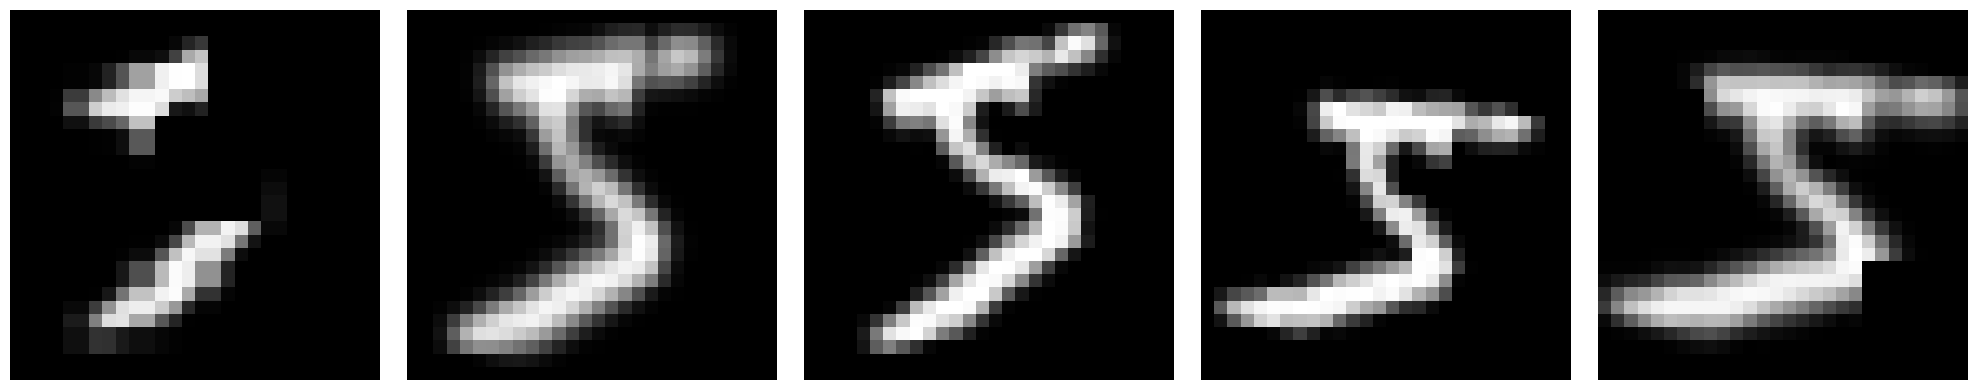

Number of samples in train dataset: 60000
Number of samples in test dataset: 10000


In [5]:
# Uncomment to visualize augmentations
visualize_augmentations(train_loader.dataset)

# # print number of samples in train and test dataset
print(f"Number of samples in train dataset: {len(train_loader.dataset)}")
print(f"Number of samples in test dataset: {len(test_loader.dataset)}")


In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 14):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

"""
train_transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.1,
        rotate_limit=15,
        p=0.7,
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),
    A.Perspective(scale=(0.05, 0.1), p=0.3, keep_size=True, pad_mode=cv2.BORDER_CONSTANT, pad_val=0),

    A.ElasticTransform(
         alpha=1.0,
         sigma=10.0,
         alpha_affine=None,  # Set to None as required by newer versions
         interpolation=cv2.INTER_LINEAR,
         border_mode=cv2.BORDER_CONSTANT,
         value=0,
         p=0.3
    ),
    
    # CoarseDropout as alternative to regular dropout
    A.CoarseDropout(
        max_holes=2,
        max_height=8,
        max_width=8,
        min_holes=1,
        fill_value=0,
        p=0.2
    ),

    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

-
loss=0.6580258011817932 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]

Test set: Average loss: 0.2339, Accuracy: 9299/10000 (92.99%)

loss=0.3493722677230835 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s] 

Test set: Average loss: 0.1302, Accuracy: 9583/10000 (95.83%)

loss=0.39144933223724365 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.77it/s]

Test set: Average loss: 0.1068, Accuracy: 9673/10000 (96.73%)

loss=0.32208719849586487 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s]

Test set: Average loss: 0.0909, Accuracy: 9710/10000 (97.10%)

loss=0.2897714078426361 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.77it/s] 

Test set: Average loss: 0.0921, Accuracy: 9717/10000 (97.17%)

loss=0.35914042592048645 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]

Test set: Average loss: 0.0801, Accuracy: 9741/10000 (97.41%)

loss=0.14843730628490448 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]

Test set: Average loss: 0.0731, Accuracy: 9754/10000 (97.54%)

loss=0.23503129184246063 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]

Test set: Average loss: 0.0671, Accuracy: 9789/10000 (97.89%)

loss=0.1971328854560852 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s] 

Test set: Average loss: 0.0719, Accuracy: 9778/10000 (97.78%)

loss=0.29275843501091003 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.85it/s]

Test set: Average loss: 0.0624, Accuracy: 9788/10000 (97.88%)

loss=0.19085021317005157 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]

Test set: Average loss: 0.0594, Accuracy: 9809/10000 (98.09%)

loss=0.4703753888607025 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s] 

Test set: Average loss: 0.0610, Accuracy: 9805/10000 (98.05%)

loss=0.2123817354440689 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s] 

Test set: Average loss: 0.0591, Accuracy: 9792/10000 (97.92%)

loss=0.35463497042655945 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.81it/s]

Test set: Average loss: 0.0574, Accuracy: 9822/10000 (98.22%)


"""

### -- Variation 1 - More Aggressive Rotations and Transformations:


In [ ]:
"""
train_transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.1,        # Increased shift
        scale_limit=0.15,       # Increased scale
        rotate_limit=30,        # Increased rotation
        p=0.8,                  # Higher probability
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.4),  # Increased distortion
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),             # More noise
    A.Perspective(scale=(0.05, 0.15), p=0.4),                 # More perspective change
    
    A.ElasticTransform(
         alpha=2.0,            # Increased deformation
         sigma=15.0,
         alpha_affine=None,
         interpolation=cv2.INTER_LINEAR,
         border_mode=cv2.BORDER_CONSTANT,
         value=0,
         p=0.4
    ),
    
    A.CoarseDropout(
        max_holes=3,           # More holes
        max_height=10,         # Larger holes
        max_width=10,
        min_holes=1,
        fill_value=0,
        p=0.3
    ),
    A.Normalize(mean=[0.1307], std=[0.3081]),
    ToTensorV2(),
])

loss=1.0413247346878052 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.30it/s]

Test set: Average loss: 0.3043, Accuracy: 9221/10000 (92.21%)

loss=0.6868762969970703 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.29it/s]

Test set: Average loss: 0.2020, Accuracy: 9476/10000 (94.76%)

loss=0.8287444114685059 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.34it/s]

Test set: Average loss: 0.1684, Accuracy: 9536/10000 (95.36%)

loss=0.8311219811439514 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.31it/s]

Test set: Average loss: 0.1504, Accuracy: 9574/10000 (95.74%)

loss=0.7059124112129211 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.33it/s]

Test set: Average loss: 0.1572, Accuracy: 9549/10000 (95.49%)

loss=0.7394788861274719 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.30it/s]

Test set: Average loss: 0.1420, Accuracy: 9598/10000 (95.98%)

loss=0.7396133542060852 batch_id=117: 100%|██████████| 118/118 [00:26<00:00,  4.38it/s]

Test set: Average loss: 0.1404, Accuracy: 9589/10000 (95.89%)

loss=0.6282297372817993 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.36it/s]

Test set: Average loss: 0.1360, Accuracy: 9614/10000 (96.14%)

loss=0.686625063419342 batch_id=117: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s] 

Test set: Average loss: 0.1268, Accuracy: 9612/10000 (96.12%)

loss=0.7198159694671631 batch_id=117: 100%|██████████| 118/118 [00:26<00:00,  4.39it/s]

Test set: Average loss: 0.1326, Accuracy: 9617/10000 (96.17%)

loss=0.5825936794281006 batch_id=117: 100%|██████████| 118/118 [00:27<00:00,  4.33it/s]

Test set: Average loss: 0.1226, Accuracy: 9632/10000 (96.32%)

loss=0.788107693195343 batch_id=117: 100%|██████████| 118/118 [00:26<00:00,  4.38it/s] 

Test set: Average loss: 0.1301, Accuracy: 9621/10000 (96.21%)

loss=0.7037412524223328 batch_id=117: 100%|██████████| 118/118 [00:26<00:00,  4.38it/s]

Test set: Average loss: 0.1246, Accuracy: 9639/10000 (96.39%)


"""

### Variation 2 - Lighter Augmentations with Focus on Noise and Dropout:

In [ ]:
"""
train_transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.05,      # Reduced shift
        scale_limit=0.05,      # Reduced scale
        rotate_limit=10,       # Reduced rotation
        p=0.6,
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),
    A.GaussNoise(var_limit=(2.0, 15.0), p=0.5),  # More frequent but lighter noise
    
    A.CoarseDropout(
        max_holes=4,           # More holes
        max_height=6,          # Smaller holes
        max_width=6,
        min_holes=2,
        fill_value=0,
        p=0.4                  # Higher dropout probability
    ),
    
    A.Blur(blur_limit=3, p=0.3),  # Added slight blur
    A.RandomBrightnessContrast(p=0.2),  # Added brightness/contrast
    
    A.Normalize(mean=[0.1307], std=[0.3081]),
    ToTensorV2(),
])

loss=0.5078465342521667 batch_id=117: 100%|██████████| 118/118 [00:22<00:00,  5.34it/s] 

Test set: Average loss: 0.1778, Accuracy: 9473/10000 (94.73%)

loss=0.24720843136310577 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s]

Test set: Average loss: 0.1285, Accuracy: 9598/10000 (95.98%)

loss=0.2728830575942993 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s] 

Test set: Average loss: 0.1147, Accuracy: 9639/10000 (96.39%)

loss=0.23713302612304688 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]

Test set: Average loss: 0.0977, Accuracy: 9691/10000 (96.91%)

loss=0.2897968590259552 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s] 

Test set: Average loss: 0.0978, Accuracy: 9692/10000 (96.92%)

loss=0.36567988991737366 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]

Test set: Average loss: 0.0852, Accuracy: 9713/10000 (97.13%)

loss=0.2408098727464676 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s] 

Test set: Average loss: 0.0848, Accuracy: 9727/10000 (97.27%)

loss=0.14981187880039215 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s]

Test set: Average loss: 0.0774, Accuracy: 9765/10000 (97.65%)

loss=0.19721554219722748 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]

Test set: Average loss: 0.0767, Accuracy: 9765/10000 (97.65%)

loss=0.19081975519657135 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]

Test set: Average loss: 0.0755, Accuracy: 9752/10000 (97.52%)

loss=0.2508995234966278 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.41it/s] 

Test set: Average loss: 0.0718, Accuracy: 9782/10000 (97.82%)

loss=0.31102558970451355 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.49it/s]

Test set: Average loss: 0.0677, Accuracy: 9786/10000 (97.86%)

loss=0.2582463324069977 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.45it/s] 

Test set: Average loss: 0.0702, Accuracy: 9765/10000 (97.65%)


"""

### Variation 3 - Focus on Geometric Transformations:

In [ ]:

"""
train_transforms = A.Compose([
    A.OneOf([
        A.ShiftScaleRotate(
            shift_limit=0.07,
            scale_limit=0.1,
            rotate_limit=20,
            p=0.8
        ),
        A.Affine(
            scale=(0.8, 1.2),
            rotate=(-20, 20),
            shear=(-10, 10),
            p=0.8
        ),
    ], p=0.9),
    
    A.GridDistortion(num_steps=6, distort_limit=0.2, p=0.4),
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.1, p=0.3),
    
    A.ElasticTransform(
         alpha=1.5,
         sigma=12.0,
         alpha_affine=None,
         p=0.4
    ),
    
    A.CoarseDropout(
        max_holes=2,
        max_height=8,
        max_width=8,
        min_holes=1,
        fill_value=0,
        p=0.2
    ),
    
    A.Normalize(mean=[0.1307], std=[0.3081]),
    ToTensorV2(),
])

loss=0.6834432482719421 batch_id=117: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s] 

Test set: Average loss: 0.1937, Accuracy: 9423/10000 (94.23%)

loss=0.3644828498363495 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.77it/s] 

Test set: Average loss: 0.1415, Accuracy: 9577/10000 (95.77%)

loss=0.37179961800575256 batch_id=117: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s]

Test set: Average loss: 0.1206, Accuracy: 9652/10000 (96.52%)

loss=0.46558475494384766 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.76it/s]

Test set: Average loss: 0.1033, Accuracy: 9701/10000 (97.01%)

loss=0.2922475337982178 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.75it/s] 

Test set: Average loss: 0.1006, Accuracy: 9696/10000 (96.96%)

loss=0.40941527485847473 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.74it/s]

Test set: Average loss: 0.0930, Accuracy: 9704/10000 (97.04%)

loss=0.3747505247592926 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.75it/s] 

Test set: Average loss: 0.0977, Accuracy: 9692/10000 (96.92%)

loss=0.26809120178222656 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.74it/s]

Test set: Average loss: 0.0844, Accuracy: 9744/10000 (97.44%)

loss=0.3604784905910492 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.74it/s] 

Test set: Average loss: 0.0853, Accuracy: 9734/10000 (97.34%)

loss=0.37283453345298767 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.73it/s]

Test set: Average loss: 0.0805, Accuracy: 9738/10000 (97.38%)

loss=0.21596936881542206 batch_id=117: 100%|██████████| 118/118 [00:25<00:00,  4.70it/s]

Test set: Average loss: 0.0787, Accuracy: 9771/10000 (97.71%)

loss=0.34595927596092224 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.73it/s]

Test set: Average loss: 0.0794, Accuracy: 9744/10000 (97.44%)

loss=0.1597621589899063 batch_id=117: 100%|██████████| 118/118 [00:25<00:00,  4.71it/s] 

Test set: Average loss: 0.0798, Accuracy: 9744/10000 (97.44%)


"""

### Variation 4 - Combination with Random Application:

In [ ]:

"""
train_transforms = A.Compose([
    A.OneOf([
        A.ShiftScaleRotate(
            shift_limit=0.0625,
            scale_limit=0.1,
            rotate_limit=15,
            p=0.8
        ),
        A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.8),
        A.ElasticTransform(
            alpha=1.0,
            sigma=10.0,
            alpha_affine=None,
            p=0.8
        ),
    ], p=0.7),
    
    A.OneOf([
        A.GaussNoise(var_limit=(5.0, 30.0), p=0.8),
        A.Blur(blur_limit=3, p=0.8),
        A.RandomBrightnessContrast(p=0.8),
    ], p=0.5),
    
    A.CoarseDropout(
        max_holes=2,
        max_height=8,
        max_width=8,
        min_holes=1,
        fill_value=0,
        p=0.3
    ),
    
    A.Normalize(mean=[0.1307], std=[0.3081]),
    ToTensorV2(),
])

loss=0.47459304332733154 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]

Test set: Average loss: 0.1772, Accuracy: 9486/10000 (94.86%)

loss=0.21334141492843628 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]

Test set: Average loss: 0.1270, Accuracy: 9609/10000 (96.09%)

loss=0.2684533894062042 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s] 

Test set: Average loss: 0.1076, Accuracy: 9678/10000 (96.78%)

loss=0.400796502828598 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]  

Test set: Average loss: 0.0978, Accuracy: 9715/10000 (97.15%)

loss=0.44975733757019043 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.92it/s]

Test set: Average loss: 0.0895, Accuracy: 9726/10000 (97.26%)

loss=0.36491188406944275 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.81it/s]

Test set: Average loss: 0.0847, Accuracy: 9734/10000 (97.34%)

loss=0.1452285796403885 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s] 

Test set: Average loss: 0.0827, Accuracy: 9737/10000 (97.37%)

loss=0.08702707290649414 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]

Test set: Average loss: 0.0806, Accuracy: 9744/10000 (97.44%)

loss=0.22423332929611206 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]

Test set: Average loss: 0.0802, Accuracy: 9757/10000 (97.57%)

loss=0.17687933146953583 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]

Test set: Average loss: 0.0764, Accuracy: 9767/10000 (97.67%)

loss=0.16285346448421478 batch_id=117: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]

Test set: Average loss: 0.0748, Accuracy: 9765/10000 (97.65%)

loss=0.2593475878238678 batch_id=117: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s] 

Test set: Average loss: 0.0729, Accuracy: 9763/10000 (97.63%)

loss=0.19869744777679443 batch_id=117: 100%|██████████| 118/118 [02:43<00:00,  1.39s/it]

Test set: Average loss: 0.0721, Accuracy: 9767/10000 (97.67%)


"""

### Variation 5 - Minimal but Targeted Augmentations:

In [ ]:

"""
train_transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.1,
        rotate_limit=15,
        p=0.9,                # Very high probability
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),
    
    A.OneOf([
        A.GaussNoise(var_limit=(5.0, 20.0), p=1.0),
        A.Blur(blur_limit=3, p=1.0),
    ], p=0.3),
    
    A.CoarseDropout(
        max_holes=1,          # Just one hole
        max_height=10,        # But potentially larger
        max_width=10,
        min_holes=1,
        fill_value=0,
        p=0.25
    ),
    
    A.Normalize(mean=[0.1307], std=[0.3081]),
    ToTensorV2(),
])

loss=0.5514877438545227 batch_id=117: 100%|██████████| 118/118 [00:17<00:00,  6.79it/s] 

Test set: Average loss: 0.1976, Accuracy: 9433/10000 (94.33%)

loss=0.1490059643983841 batch_id=117: 100%|██████████| 118/118 [00:17<00:00,  6.90it/s] 

Test set: Average loss: 0.1270, Accuracy: 9632/10000 (96.32%)

loss=0.3203728497028351 batch_id=117: 100%|██████████| 118/118 [00:17<00:00,  6.89it/s] 

Test set: Average loss: 0.1035, Accuracy: 9678/10000 (96.78%)

loss=0.40590357780456543 batch_id=117: 100%|██████████| 118/118 [00:16<00:00,  7.03it/s]

Test set: Average loss: 0.0958, Accuracy: 9716/10000 (97.16%)

loss=0.4559806287288666 batch_id=117: 100%|██████████| 118/118 [00:16<00:00,  7.10it/s] 

Test set: Average loss: 0.0871, Accuracy: 9723/10000 (97.23%)

loss=0.2535381317138672 batch_id=117: 100%|██████████| 118/118 [00:16<00:00,  6.97it/s] 

Test set: Average loss: 0.0924, Accuracy: 9729/10000 (97.29%)

loss=0.282307893037796 batch_id=117: 100%|██████████| 118/118 [00:16<00:00,  6.99it/s]  

Test set: Average loss: 0.0892, Accuracy: 9732/10000 (97.32%)

loss=0.16792957484722137 batch_id=117: 100%|██████████| 118/118 [00:17<00:00,  6.82it/s]

Test set: Average loss: 0.0811, Accuracy: 9764/10000 (97.64%)

loss=0.2787671387195587 batch_id=117: 100%|██████████| 118/118 [00:17<00:00,  6.72it/s] 

Test set: Average loss: 0.0829, Accuracy: 9743/10000 (97.43%)

loss=0.2796783149242401 batch_id=117: 100%|██████████| 118/118 [00:17<00:00,  6.73it/s] 

Test set: Average loss: 0.0750, Accuracy: 9747/10000 (97.47%)

loss=0.180215522646904 batch_id=117: 100%|██████████| 118/118 [00:17<00:00,  6.80it/s]  

Test set: Average loss: 0.0726, Accuracy: 9780/10000 (97.80%)

loss=0.23531754314899445 batch_id=117: 100%|██████████| 118/118 [00:16<00:00,  6.95it/s]

Test set: Average loss: 0.0690, Accuracy: 9795/10000 (97.95%)

loss=0.1926894187927246 batch_id=117: 100%|██████████| 118/118 [00:17<00:00,  6.89it/s] 

Test set: Average loss: 0.0724, Accuracy: 9776/10000 (97.76%)


"""